agent最简单的配置就是一个搭配了llm_with_tools的chatbot和一个工具集  
chatbot将用户query和tools上下文输入到llm，llm返回可能得调用工具的信息，包括tool_name, tool_arg, tool_call_id等

工具集节点接收chatbox返回的状态信息，对工具进行调用，tool.invoke,返回结果，作为observation传递给chatbot.


In [8]:
import os
from typing_extensions import Literal
from langchain_community.chat_models import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from pydantic import BaseModel, Field
import operator
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

In [ ]:
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "agent"

In [2]:
llm = ChatTongyi(
    model="qwen-max",
)

In [4]:
# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [6]:
tools_by_name

{'add': StructuredTool(name='add', description='Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000021CDCB28CC0>),
 'multiply': StructuredTool(name='multiply', description='Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000021CDCB285E0>),
 'divide': StructuredTool(name='divide', description='Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x0000021CDD9598A0>)}

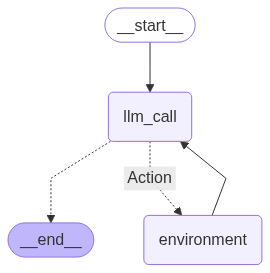

In [13]:
# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["Action", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [15]:
# Invoke
messages = [HumanMessage(content="七加八等于几")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

七加八等于几
================================== Ai Message ==================================
Tool Calls:
  add (call_ac14398ce27a4f45b280e9)
 Call ID: call_ac14398ce27a4f45b280e9
  Args:
    a: 7
    b: 8
================================= Tool Message =================================

15
================================== Ai Message ==================================

七加八等于15。


**说明**：MessagesState定义有Annotated[list[AnyMessage], add_messages],所以传进去的messages会一直累加。

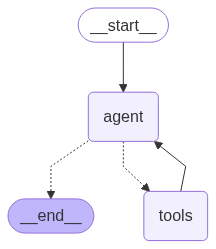

In [17]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))


In [18]:

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_e986109d3a864bf6afc916)
 Call ID: call_e986109d3a864bf6afc916
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [19]:
from langgraph.prebuilt import ToolNode, tools_condition

In [21]:
tools_condition?

Signature:
tools_condition(
    state: Union[list[Annotated[Union[Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], Annotated[langchain_core.messages.function.FunctionMessageChunk, Tag(tag='FunctionMessageChunk')], Annotated[langchain_core.messages.tool.ToolMessag